# Libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from pandas.plotting import table
from scipy.stats import kruskal



import warnings
warnings.filterwarnings("ignore")


# Dataset

## Loading Data

Downloading data from Kaggle

In [2]:
path = kagglehub.dataset_download("arashnic/fitbit")

print("Path to dataset files:", path)

100%|██████████| 43.3M/43.3M [00:00<00:00, 64.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/fitbit/versions/2


In [3]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (343 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123632 files and directories currently install

Visualizing directory structure.

In [4]:
!tree –dirsfirst	 /root/.cache/kagglehub/datasets/arashnic/fitbit/versions/2/

–dirsfirst  [error opening dir]
/root/.cache/kagglehub/datasets/arashnic/fitbit/versions/2/
├── mturkfitbit_export_3.12.16-4.11.16
│   └── Fitabase Data 3.12.16-4.11.16
│       ├── dailyActivity_merged.csv
│       ├── heartrate_seconds_merged.csv
│       ├── hourlyCalories_merged.csv
│       ├── hourlyIntensities_merged.csv
│       ├── hourlySteps_merged.csv
│       ├── minuteCaloriesNarrow_merged.csv
│       ├── minuteIntensitiesNarrow_merged.csv
│       ├── minuteMETsNarrow_merged.csv
│       ├── minuteSleep_merged.csv
│       ├── minuteStepsNarrow_merged.csv
│       └── weightLogInfo_merged.csv
└── mturkfitbit_export_4.12.16-5.12.16
    └── Fitabase Data 4.12.16-5.12.16
        ├── dailyActivity_merged.csv
        ├── dailyCalories_merged.csv
        ├── dailyIntensities_merged.csv
        ├── dailySteps_merged.csv
        ├── heartrate_seconds_merged.csv
        ├── hourlyCalories_merged.csv
        ├── hourlyIntensities_merged.csv
        ├── hourlySteps_merged.csv
        ├── min

Our analysis will be done with daily data. We notice that folders for each respective months have similar files but the one for the first month is missing some. The dailyActivity_merged.csv contains all the data we will require in terms of activities. However, as seen the data for sleep has only bee aggregated for the second month which means it will have to be done for the first month using the minuteSleep_merged.csv file. From this file we also want to obtain the time the user woke up and the time the user went to sleep. Additionally,  from the heartrate_seconds_merged.csv we want to obtain the average resting heart rate for each sleep.

In [5]:
root_paths = [path + "/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/", path + "/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/"]

## Data Preprocessing

### Activities Data

We concatenate the daily activities for both months given that both contain the same columns.

In [6]:
daily_activity_df1 = pd.read_csv(root_paths[0] + "dailyActivity_merged.csv")
daily_activity_df2 = pd.read_csv(root_paths[1] + "dailyActivity_merged.csv")

In [7]:
daily_activity_df1.query("ActivityDate == '4/12/2016'").head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
18,1503960366,4/12/2016,224,0.14,0.14,0.0,0.00,0.00,0.13,0.0,0,0,9,32,50
37,1624580081,4/12/2016,6627,4.31,4.31,0.0,0.00,0.00,4.31,0.0,0,0,89,604,706
59,1844505072,4/12/2016,0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0,0,0,426,399
71,1927972279,4/12/2016,24,0.02,0.02,0.0,0.00,0.00,0.02,0.0,0,0,3,161,942
83,2022484408,4/12/2016,6717,4.72,4.72,0.0,3.23,0.22,1.27,0.0,41,5,67,551,1140


In [8]:
daily_activity_df2.query("ActivityDate == '4/12/2016'").head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
31,1624580081,4/12/2016,8163,5.31,5.31,0.0,0.00,0.00,5.31,0.0,0,0,146,1294,1432
62,1644430081,4/12/2016,10694,7.77,7.77,0.0,0.14,2.30,5.33,0.0,2,51,256,1131,3199
92,1844505072,4/12/2016,6697,4.43,4.43,0.0,0.00,0.00,4.43,0.0,0,0,339,1101,2030
123,1927972279,4/12/2016,678,0.47,0.47,0.0,0.00,0.00,0.47,0.0,0,0,55,734,2220


Both datasets contain the 12th of April. It is hard to know why or what is going on but it is clear daily_activity_df2 contains more complete data for this date, thus we drop the values for this date in daily_activity_df1.

In [9]:
daily_activity_df1 = daily_activity_df1[daily_activity_df1.ActivityDate != "4/12/2016"]
daily_activity_df = pd.concat([daily_activity_df1, daily_activity_df2])
daily_activity_df["ActivityDate"] = pd.to_datetime(daily_activity_df["ActivityDate"])
daily_activity_df.drop_duplicates()
daily_activity_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-03-25,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,2016-03-26,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,2016-03-27,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,2016-03-28,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,2016-03-29,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886


In [10]:
daily_activity_df[daily_activity_df['ActivityDate'] == pd.to_datetime('2016-04-12')]["Id"].value_counts().unique()

array([1])

We confirm no more duplicates for a user in the same date.

### Sleep Data
Processing the sleep data isn't as straightforward. There is a sleepDay_merged.csv which contains total sleep records, total minutes asleep, total time in bed for each user every day but this is only present for the second month. Additionally, there are other metrics which are not included in the sleep day dataset which need to be extracted such as sleeping hour, wake up hour and average resting heart rate. For these we use the minute level sleep data as well as the 5 second level data from heart rate. The data is processed as shown below.

In [11]:
def process_minute_sleep_data(minute_sleep_filepath):
  """
    Processes minute-level sleep data and extracts daily sleep patterns.

    Parameters
    ----------
    minute_sleep_filepath : str
        Filepath to the CSV file containing minute-level sleep data.

    Returns
    -------
    tuple
        - pandas.DataFrame: A DataFrame containing the processed minute-level sleep data with additional columns.
        - pandas.Series: A Series identifying the logId corresponding to the longest sleep duration for each user on each day.
    """
  minute_sleep_df = pd.read_csv(minute_sleep_filepath)
  minute_sleep_df["date"] = pd.to_datetime(minute_sleep_df["date"])


  # calculations to get the SleepDay of a particular log (it is taken as the day when the person wakes up)
  date_dict = minute_sleep_df.groupby("logId").agg(SleepDay=("date",lambda x: max(x).date()), )["SleepDay"].to_dict()
  minute_sleep_df["SleepDay"] = list(map(lambda logId: date_dict[logId],minute_sleep_df["logId"]))


  # calculations to get sleep and awake time (if multiple logs in a day picks the longest one and considers the other one a nap)
  log_sleep_durations = minute_sleep_df.groupby(["Id","logId","SleepDay"]).agg(LogSleepTime=("date",lambda x: (max(x)-min(x)).total_seconds()/60)).reset_index()
  log_max_sleep_per_userDay = log_sleep_durations.groupby(["Id", "SleepDay"]).agg(
      logId=("logId", lambda x: x.iloc[(x.index.get_level_values(0) == x.name[0]).argmax()])).logId

  minute_sleep_df = minute_sleep_df[minute_sleep_df.logId.isin(log_max_sleep_per_userDay)]

  return minute_sleep_df, log_max_sleep_per_userDay

In [12]:
def process_heartrate_seconds(heartrate_filepath, minutes_sleep_df, log_max_sleep_per_userDay):
  """
    Processes heartrate data and calculates average resting heart rate during the longest sleep periods.

    Parameters
    ----------
    heartrate_filepath : str
        Filepath to the CSV file containing second-level heartrate data.
    minutes_sleep_df : pandas.DataFrame
        DataFrame containing minute-level sleep data, with SleepDay identified for each logId.
    log_max_sleep_per_userDay : pandas.Series
        Series identifying the logId corresponding to the longest sleep duration for each user on each day.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing 'Id', 'SleepDay', and the calculated 'AverageRestingHeartRate' for the longest sleep logs.
    """
  heartrate_df = pd.read_csv(heartrate_filepath)
  heartrate_df["Time"] = pd.to_datetime(heartrate_df["Time"])
  heartrate_df["date"]= heartrate_df.Time.dt.date


  # Calculating time range for log with longest sleep time per user per day
  log_time_ranges = minutes_sleep_df.query(f"logId in {list(log_max_sleep_per_userDay)}").groupby(["Id","SleepDay","logId"]).agg(StartTime=("date","min"),
                                                                                                         EndTime=("date","max")).reset_index().drop("logId",axis=1)

  # Calculatig average resting heart rate for log with longest sleep time per user per day
  average_resting_heart_rates = []
  for _, row in log_time_ranges.iterrows():
    average_resting_heart_rates.append(
    heartrate_df.loc[(heartrate_df["Id"] == row["Id"]) &
                      (heartrate_df["Time"] >= row["StartTime"]) &
                      (heartrate_df["Time"] <= row["EndTime"]), "Value"].mean()
    )

  heartrate_df = log_time_ranges.drop(["StartTime","EndTime"], axis=1)
  heartrate_df["AverageRestingHeartRate"] = average_resting_heart_rates
  heartrate_df.dropna()

  return heartrate_df

In [13]:
def process_datasets(minute_sleep_filepath, heartrate_filepath):
  """
    Processes sleep and heartrate datasets to generate a summary of sleep metrics.

    Parameters
    ----------
    minute_sleep_filepath : str
        Filepath to the CSV file containing minute-level sleep data.
    heartrate_filepath : str
        Filepath to the CSV file containing second-level heartrate data.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing daily sleep metrics, including:
        - Sleep patterns (total sleep records, total minutes asleep, total time in bed).
        - Sleep schedule (hour the user fell asleep and woke up).
        - Average resting heart rate during sleep.
        Sorted by 'Id' and 'SleepDay'.
    """
  minutes_sleep_df, log_max_sleep_per_userDay = process_minute_sleep_data(minute_sleep_filepath)
  heartrate_df = process_heartrate_seconds(heartrate_filepath, minutes_sleep_df, log_max_sleep_per_userDay)


  # creating and mergin final daily_sleep_df
  daily_sleep_df1 = minutes_sleep_df.groupby(["Id","SleepDay"]).agg(TotalSleepRecords=("logId", lambda x: len(x.unique())),
                                           TotalMinutesAsleep=("value", lambda sleep_codes: sum(sleep_codes[sleep_codes==1])),
                                           TotalTimeInBed=("value","count")).reset_index()

  daily_sleep_df2 = minutes_sleep_df.query(f"logId in {list(log_max_sleep_per_userDay)}").groupby(["Id","SleepDay","logId"]).agg(SleepHour=("date",lambda x: min(x).hour),
                                                                                                          AwakeHour=("date",lambda x: max(x).hour)).reset_index().drop("logId",axis=1)

  daily_sleep_df = daily_sleep_df1.merge(daily_sleep_df2, on=["Id","SleepDay"])

  daily_sleep_df = daily_sleep_df.merge(heartrate_df, on=["Id","SleepDay"], how="left")
  daily_sleep_df["SleepDay"] = pd.to_datetime(daily_sleep_df["SleepDay"])

  return daily_sleep_df.sort_values(by=["Id", "SleepDay"]).reset_index(drop=True)


In [14]:
daily_sleep_df = pd.concat(process_datasets(root_path + "minuteSleep_merged.csv", root_path + "heartrate_seconds_merged.csv") for root_path in root_paths)
daily_sleep_df = daily_sleep_df.drop_duplicates()
daily_sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepHour,AwakeHour,AverageRestingHeartRate
0,1503960366,2016-03-13,1,411,426,2,9,NaN
1,1503960366,2016-03-14,1,354,386,1,7,NaN
2,1503960366,2016-03-15,1,312,335,2,8,NaN
3,1503960366,2016-03-16,1,272,303,3,8,NaN
4,1503960366,2016-03-17,1,402,437,1,8,NaN


In [15]:
april_12_user_counts = daily_sleep_df[daily_sleep_df['SleepDay'] == pd.to_datetime('2016-04-12')]["Id"].value_counts()
duplicate_ids = list(april_12_user_counts[april_12_user_counts > 1].index)
daily_sleep_df[(daily_sleep_df['SleepDay'] == pd.to_datetime('2016-04-12')) & (daily_sleep_df["Id"].isin(duplicate_ids))]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepHour,AwakeHour,AverageRestingHeartRate
254,5553957443,2016-04-12,1,441,464,22,6,58.536310
226,5553957443,2016-04-12,1,441,464,22,6,58.278006


Once again we notice we have multiple registers for the same user on the 12th April (the day some of the data intersects). However, there is no clear patter in the differences so we just select the first occurence for each.

In [16]:
daily_sleep_df = daily_sleep_df.groupby(["Id","SleepDay"]).first().reset_index()

### Dealing with incomplete user data


In [17]:
print("Total Actvity Users:", len(daily_activity_df.Id.unique()))
print("Total Sleep Users:", len(daily_sleep_df.Id.unique()))

Total Actvity Users: 35
Total Sleep Users: 25


In [18]:
print("User difference: ", len(set(daily_activity_df.Id.unique()).difference(set(daily_sleep_df.Id.unique()))))

User difference:  10


This confirms that all users in daily_sleep_df are included in daily_activity_df. As the research problem focuses on comparing sleep to exercise/activity we will filter out of the daily_activity_df those users which are not included in daily_sleep_df.

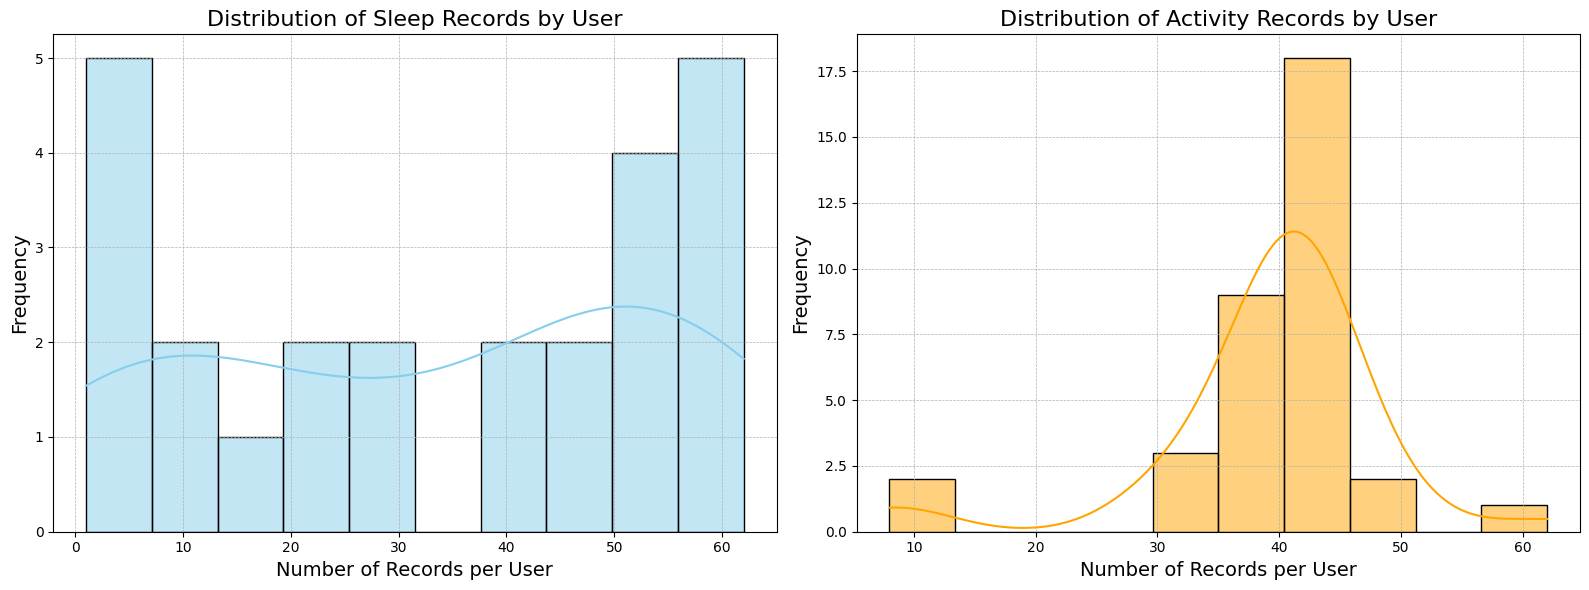

In [19]:
id_counts_sleep = daily_sleep_df['Id'].value_counts()
id_counts_activity = daily_activity_df['Id'].value_counts()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(id_counts_sleep, bins=10, kde=True, color='skyblue')
plt.title('Distribution of Sleep Records by User', fontsize=16)
plt.xlabel('Number of Records per User', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
sns.histplot(id_counts_activity, bins=10, kde=True, color='orange')
plt.title('Distribution of Activity Records by User', fontsize=16)
plt.xlabel('Number of Records per User', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
#plt.savefig("histogram__records_by_user.png", format='png', dpi=2000)
plt.show()



We notice data is very incomplete, with most users lacking a lot of days. To have enough data to represent each user while also maintaining good representation of the distinct users a threshold of 20 is set. This ensures all users logged data for at least 1/3 of the days.

In [20]:
user_ids = list(id_counts_sleep[id_counts_sleep >= 20].index)
daily_sleep_df = daily_sleep_df[daily_sleep_df.Id.isin(user_ids)]
daily_activity_df = daily_activity_df[daily_activity_df.Id.isin(user_ids)]

user_ids = list(id_counts_activity[id_counts_activity >= 20].index)
daily_sleep_df = daily_sleep_df[daily_sleep_df.Id.isin(user_ids)]
daily_activity_df = daily_activity_df[daily_activity_df.Id.isin(user_ids)]

daily_activity_df = daily_activity_df.rename(columns={"ActivityDate":"Date"})
daily_sleep_df = daily_sleep_df.rename(columns={"SleepDay":"Date"})

In [21]:
final_df = daily_sleep_df.merge(daily_activity_df, on=["Id","Date"], how="outer").drop_duplicates()

In [22]:
sum(final_df["SedentaryMinutes"] == 24*60)

68

In [23]:
sum(final_df["TotalDistance"] == 0)

59

In [24]:
final_df = final_df[(final_df["SedentaryMinutes"] != 24*60) & (final_df["TotalDistance"] != 0)]

Another big problem was that for many records the sedentary time was 1440 which basically means the fitbit was on but not being used, a total distance of 0 meant the fitbit might has been on and tracking at some point in the day but it was never used. Thus, this most be removed as they can affect the data analysis and results.

In [25]:
final_df.head()

,Id,Date,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepHour,AwakeHour,AverageRestingHeartRate,TotalSteps,TotalDistance,...,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-03-13,1.0,411.0,426.0,2.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1503960366,2016-03-14,1.0,354.0,386.0,1.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1503960366,2016-03-15,1.0,312.0,335.0,2.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1503960366,2016-03-16,1.0,272.0,303.0,3.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1503960366,2016-03-17,1.0,402.0,437.0,1.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values

In [26]:
final_df.isna().sum()/final_df.shape[0]

,0
Id,0.000000
Date,0.000000
TotalSleepRecords,0.112500
TotalMinutesAsleep,0.112500
TotalTimeInBed,0.112500
SleepHour,0.112500
AwakeHour,0.112500
AverageRestingHeartRate,0.734091
TotalSteps,0.252273
TotalDistance,0.252273


Around 11% of records are missing for sleep records and 25% for activity records. Average Resting Heart Rate has a lot more missing values with around 75%. The sleep and activity records will be imputed using a KNN Imputer with n_neighbors=20, however, to ensure more reliabilty the data will first be scaled, then imputed and then unscaled once again to have our final values for analysis. The imputation will exclude Average Resting Heart Rate as there are too many missing values but this column will not be completely removed as it will be use for a smaller focused analysis. Id and Date are of course excluded as well from imputation.

In [27]:
def circular_mean(series):
    """
    Compute the circular mean of a given series of hours (24-hour format).

    The circular mean is the average of the values on a circular scale (i.e., in the context of time, where 0 and 24 represent the same point in time).
    This method calculates the mean angle using the sine and cosine components to account for the cyclical nature of hours.

    Parameters:
    -----------
    series : pandas.Series or array-like
        A series or array containing time values in hours (24-hour format), typically representing `AwakeHour` or `SleepHour`.

    Returns:
    --------
    float
        The circular mean (average) hour, adjusted to be within the range [0, 24). This is the most representative "time"
        accounting for the cyclical nature of time, e.g., the mean of 23:00 and 1:00 will be correctly calculated as around 0:00.
    """
    # Convert hours to radians (1 hour = 15 degrees, as there are 360 degrees in a full circle)
    radians = np.deg2rad(series * 15)

    sin_component = np.sin(radians)
    cos_component = np.cos(radians)

    mean_sin = np.mean(sin_component)
    mean_cos = np.mean(cos_component)

    mean_angle = np.arctan2(mean_sin, mean_cos)

    mean_time = (np.rad2deg(mean_angle) / 15) % 24

    return mean_time


In [28]:
missing_data_columns_knn = list(final_df.drop(columns=["Id", "Date", "AverageRestingHeartRate", "AwakeHour", "SleepHour"]).columns)
missing_data_columns_circular_mean = ["AwakeHour", "SleepHour"]

imputed_groups = []

grouped = final_df.groupby("Id")

for id_val, group in grouped:
    # For non-circular data, apply KNN imputation
    missing_data = group[missing_data_columns_knn]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(missing_data)

    imputer = KNNImputer(n_neighbors=3)
    imputed_scaled_data = imputer.fit_transform(scaled_data)

    imputed_data = scaler.inverse_transform(imputed_scaled_data)

    # For circular data  apply circular mean imputation
    for column in missing_data_columns_circular_mean:
        missing_mask = group[column].isna()
        if missing_mask.any():
            # Calculate circular mean of non-missing values
            mean_value = circular_mean(group[column].dropna())
            group.loc[missing_mask, column] = mean_value

    imputed_group = group.copy()
    imputed_group[missing_data_columns_knn] = imputed_data

    imputed_groups.append(imputed_group)

final_imputed_df = pd.concat(imputed_groups).sort_index()



Some columns are integers so they need to be converted back through rounding. Additionally, for consistency, Total Distance is modified to be the sum of the different intensities distances (Very Active + Moderately + Light + Sedentary)

In [29]:
final_df = final_imputed_df.copy()
int_columns = ["TotalSleepRecords","TotalMinutesAsleep","TotalTimeInBed","SleepHour","AwakeHour",
               "VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes", "SedentaryMinutes", "Calories","TotalSteps"]
final_df[int_columns] = final_df[int_columns].round().astype(int)
final_df = final_df.drop(columns=["TrackerDistance","LoggedActivitiesDistance"])
final_df["TotalDistance"] = final_df["VeryActiveDistance"] + final_df["ModeratelyActiveDistance"] + final_df["LightActiveDistance"] + final_df["SedentaryActiveDistance"]

Now we are left with our final dataset ready for analysis with only missing values in the average resting heart rate.

In [30]:
final_df.head()

,Id,Date,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepHour,AwakeHour,AverageRestingHeartRate,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-03-13,1,411,426,2,9,NaN,11491,7.296667,2.873333,0.963333,3.460000,0.0,40,24,221,716,1827
1,1503960366,2016-03-14,1,354,386,1,7,NaN,12472,8.000000,2.513333,0.806667,4.680000,0.0,34,20,237,766,1885
2,1503960366,2016-03-15,1,312,335,2,8,NaN,12917,8.320000,2.620000,0.793333,4.906667,0.0,36,19,240,817,1912
3,1503960366,2016-03-16,1,272,303,3,8,NaN,14891,9.700000,3.293333,0.793333,5.613333,0.0,42,19,291,783,2026
4,1503960366,2016-03-17,1,402,437,1,8,NaN,11484,7.283333,2.203333,1.320000,3.760000,0.0,32,33,247,698,1847


# Final Dataset Description

In [31]:
final_df.describe()

,Id,Date,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepHour,AwakeHour,AverageRestingHeartRate,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,8.800000e+02,880,880.0,880.000000,880.000000,880.000000,880.000000,234.000000,880.000000,880.000000,880.000000,8.800000e+02,880.000000,8.800000e+02,880.000000,880.000000,880.000000,880.000000,880.000000
mean,4.831746e+09,2016-04-12 05:07:38.181818112,1.0,394.893182,427.348864,14.553409,6.611364,61.784541,8092.581818,5.648625,1.263405,7.001742e-01,3.684117,9.280303e-04,22.675000,16.676136,211.081818,764.587500,2382.415909
min,1.503960e+09,2016-03-12 00:00:00,1.0,56.000000,62.000000,0.000000,0.000000,47.454924,16.000000,0.010000,0.000000,-6.938894e-18,0.010000,-2.168404e-19,0.000000,0.000000,2.000000,0.000000,52.000000
25%,3.977334e+09,2016-03-29 00:00:00,1.0,325.000000,364.000000,2.000000,5.000000,57.102672,4761.250000,3.215000,0.000000,0.000000e+00,2.490833,0.000000e+00,0.000000,0.000000,155.000000,653.000000,1898.750000
50%,4.445115e+09,2016-04-13 00:00:00,1.0,412.000000,443.500000,21.000000,6.000000,62.093124,8439.500000,6.081667,0.530000,4.300000e-01,3.610000,0.000000e+00,8.000000,11.000000,206.000000,729.500000,2208.500000
75%,6.117666e+09,2016-04-27 00:00:00,1.0,475.000000,506.250000,22.000000,8.000000,66.047865,10904.500000,7.710000,2.198333,9.700000e-01,4.810000,0.000000e+00,33.250000,25.000000,261.250000,823.250000,2842.000000
max,8.792010e+09,2016-05-12 00:00:00,1.0,1040.000000,1086.000000,24.000000,23.000000,130.101598,22770.000000,17.550000,9.890000,6.480000e+00,12.510000,1.100000e-01,210.000000,143.000000,518.000000,1438.000000,4900.000000
std,2.111554e+09,NaN,0.0,118.804818,123.742512,9.949216,2.475612,8.084716,4058.129927,2.899720,1.635463,9.203565e-01,1.758700,7.777065e-03,32.558428,20.142911,87.183238,213.434276,710.610359


We see that everythings seems normal except for the averages in sleep hour which are mainly due to the fact that we are just taking the raw hour of day so if someone sleeps at 2am and someone else sleeps at 10 pm the average would be (22+2)/2=12 which of course is not the right way too interpret.

In [32]:
print("Unique Users: ", final_df.Id.unique().size)

Unique Users:  17


In [33]:
print("Total Records: ", final_df.shape[0])

Total Records:  880


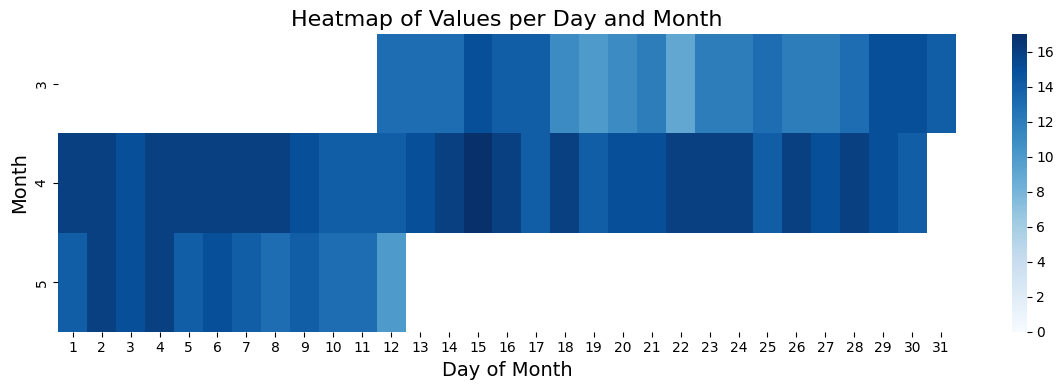

In [34]:
heatmap_data = final_df[["Date"]]
heatmap_data["Day"] = heatmap_data['Date'].dt.day
heatmap_data["Month"] = heatmap_data['Date'].dt.month
heatmap_data = heatmap_data.groupby(['Month', 'Day']).size().unstack(fill_value=np.nan)


plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, cmap="Blues", cbar=True, vmin=0)

plt.title('Heatmap of Values per Day and Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Month', fontsize=14)

# Show the plot
plt.tight_layout()
#plt.savefig("heatmap_records_per_day.png", format='png', dpi=2000)
plt.show()


We notice that for most of the dates we have incomplete data for all 17 users. However, all days contain record of at least 10 or more users which should suffice for annalysis.

# Methods/ EDA

In [35]:
final_df.columns

Index(['Id', 'Date', 'TotalSleepRecords', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'SleepHour', 'AwakeHour', 'AverageRestingHeartRate',
       'TotalSteps', 'TotalDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')

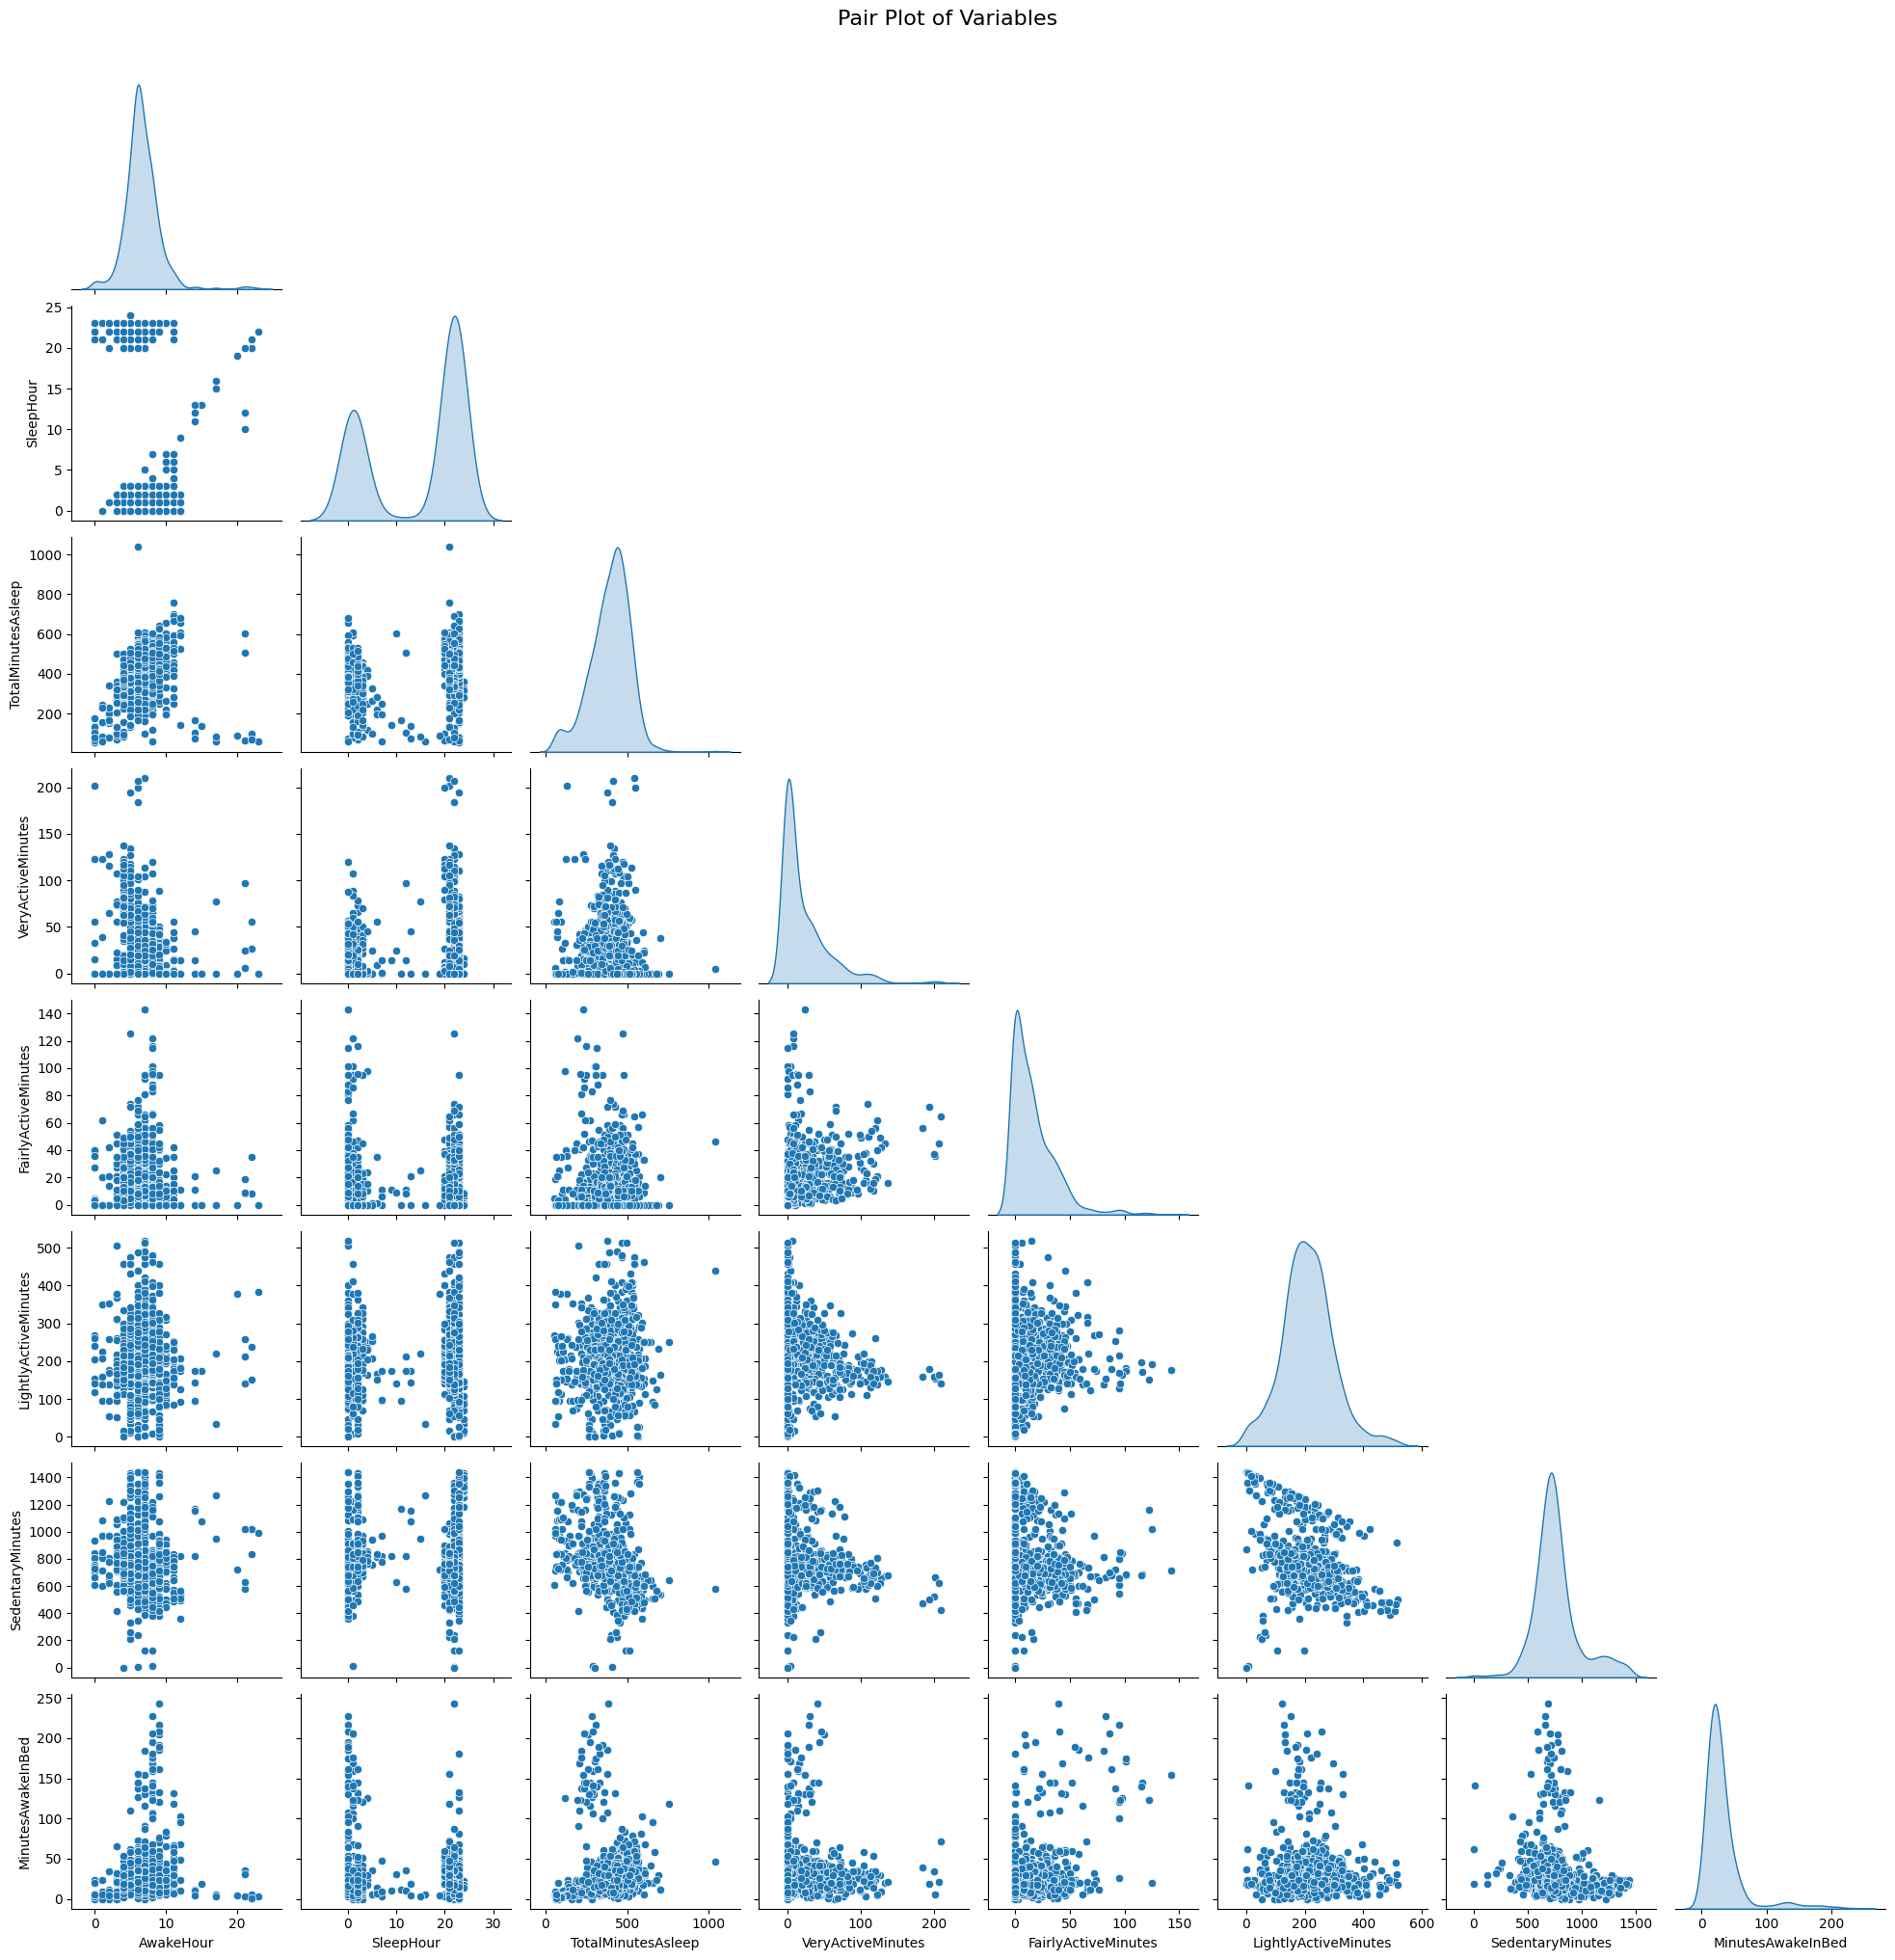

In [36]:
corr_df = final_df[["AwakeHour", "SleepHour",'TotalMinutesAsleep', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes']]
corr_df["MinutesAwakeInBed"] = final_df["TotalTimeInBed"] - final_df["TotalMinutesAsleep"]



sns.pairplot(corr_df, diag_kind='kde', corner=True, height=2.5)

plt.suptitle("Pair Plot of Variables", y=1.02, fontsize=16)
plt.show()

No obvious pattern is seen.

## Descriptive Statistics

In [37]:
descriptive_df = final_df[["Id","Date","TotalMinutesAsleep","AverageRestingHeartRate", "LightActiveDistance","LightlyActiveMinutes","SedentaryMinutes", "AwakeHour","SleepHour", "TotalSteps", "Calories"]]
descriptive_df["ActiveDistance"] = final_df["VeryActiveDistance"] + final_df["ModeratelyActiveDistance"]
descriptive_df["ActiveMinutes"] = final_df["VeryActiveMinutes"] + final_df["FairlyActiveMinutes"]

descriptive_df["MinutesAwakeBed"] = final_df["TotalTimeInBed"] - final_df["TotalMinutesAsleep"]
columns_miutes= ["TotalMinutesAsleep", "MinutesAwakeBed","ActiveMinutes","LightlyActiveMinutes","SedentaryMinutes"]
columns_kilometres = ["ActiveDistance","LightActiveDistance"]
columns_bpm = ["AverageRestingHeartRate"]
columns_time = ["AwakeHour","SleepHour"]


It is important to first understand the distribution of each of our variables to identify any anomalies and gain a better understanding of the data, which may help uncover patterns. By examining the distribution of both minute-based and distance-based features, we can assess how they vary across users and detect any unusual trends or inconsistencies that might require further investigation.

In [38]:
descriptive_df.describe()

,Id,Date,TotalMinutesAsleep,AverageRestingHeartRate,LightActiveDistance,LightlyActiveMinutes,SedentaryMinutes,AwakeHour,SleepHour,TotalSteps,Calories,ActiveDistance,ActiveMinutes,MinutesAwakeBed
count,8.800000e+02,880,880.000000,234.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,8.800000e+02,880.000000,880.000000
mean,4.831746e+09,2016-04-12 05:07:38.181818112,394.893182,61.784541,3.684117,211.081818,764.587500,6.611364,14.553409,8092.581818,2382.415909,1.963580e+00,39.351136,32.455682
min,1.503960e+09,2016-03-12 00:00:00,56.000000,47.454924,0.010000,2.000000,0.000000,0.000000,0.000000,16.000000,52.000000,-6.938894e-18,0.000000,0.000000
25%,3.977334e+09,2016-03-29 00:00:00,325.000000,57.102672,2.490833,155.000000,653.000000,5.000000,2.000000,4761.250000,1898.750000,0.000000e+00,0.000000,16.000000
50%,4.445115e+09,2016-04-13 00:00:00,412.000000,62.093124,3.610000,206.000000,729.500000,6.000000,21.000000,8439.500000,2208.500000,1.386667e+00,28.000000,23.500000
75%,6.117666e+09,2016-04-27 00:00:00,475.000000,66.047865,4.810000,261.250000,823.250000,8.000000,22.000000,10904.500000,2842.000000,3.403333e+00,61.000000,36.000000
max,8.792010e+09,2016-05-12 00:00:00,1040.000000,130.101598,12.510000,518.000000,1438.000000,23.000000,24.000000,22770.000000,4900.000000,1.222000e+01,275.000000,243.000000
std,2.111554e+09,NaN,118.804818,8.084716,1.758700,87.183238,213.434276,2.475612,9.949216,4058.129927,710.610359,2.081107e+00,43.909677,33.474597


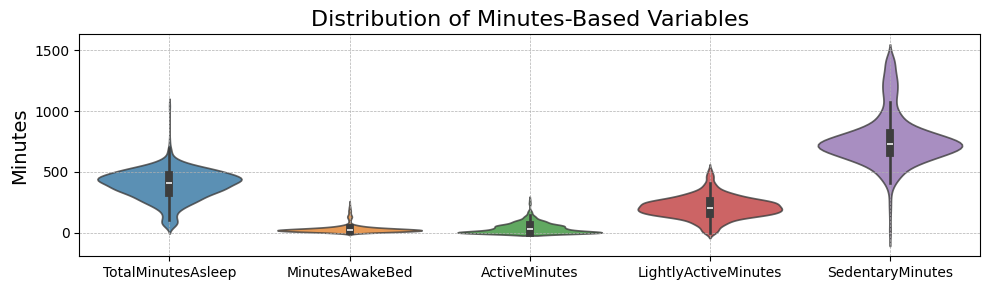

In [39]:
plt.figure(figsize=(10, 3))
sns.violinplot(data=descriptive_df[columns_miutes], alpha=0.8)
plt.title("Distribution of Minutes-Based Variables", fontsize=16)
plt.ylabel("Minutes", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig("minute_based_distributions.png", format='png', dpi=2000)
plt.show()

 The plot shows how the minute based variables are distributed. We can see that total minutes asleep is and lightly active minutes are almost normally distributed with a  and a median of  412 (~7 hours) and 206 minutes respectively. We also notice that the minutes awake in bed is right skewed with most values around 15-35 minutes but with a lot of high values some even above 200 minutes indicating sleeping problems for certain users. The sedentary minutes distribution is right skewed and is by far the one with the highest amount of minutes, indicating that most users spend most of their days not moving around, in large this is due because the sedentary minutes also includes the minutes asleep (Fitabase, 2024). The active minutes is very right skewed with a floor effect indicating, as expected, that most users have small levels of intense activity during their days with some exceptions, as the upper quartile is around 1 hour of intense active movement.

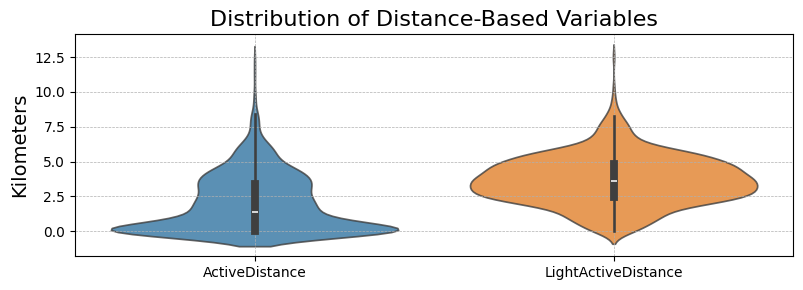

In [40]:
plt.figure(figsize=(8, 3))
sns.violinplot(data=descriptive_df[columns_kilometres], alpha=0.8)
plt.title("Distribution of Distance-Based Variables", fontsize=16)
plt.ylabel("Kilometers", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig("distance_based_distributions.png", format='png', dpi=2000)
plt.show()

In [41]:
print("Active Distance and Minutes Correlation: ", descriptive_df[['ActiveMinutes','ActiveDistance']].corr().iloc[0,1])
print("Light Active Distance and Minutes Correlation: ", descriptive_df[['LightlyActiveMinutes','LightActiveDistance']].corr().iloc[0,1])

Active Distance and Minutes Correlation:  0.8884180131540944
Light Active Distance and Minutes Correlation:  0.8761216605280094



In the plot we can see how the distance based features are distributed. They mainly follow the same distribution as their minutes based counterparts (active minutes and light active minutes). In fact, the pearson correlation coefficient is 0.89 and 0.88 between active minutes vs. distance and light active minutes vs. distance respectively. As both their distributions are very similar it makes more sense to just use the minute based, since people have different rythms time is a better indicator.

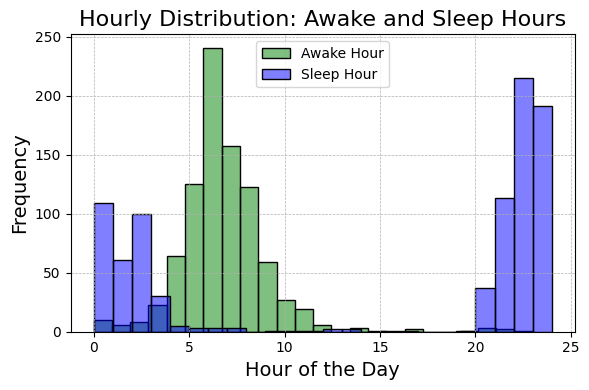

In [42]:
plt.figure(figsize=(6, 4))
sns.histplot(final_df["AwakeHour"], bins=24, kde=False, color='green', alpha=0.5, label='Awake Hour')
sns.histplot(final_df["SleepHour"], bins=24, kde=False, color='blue', alpha=0.5, label='Sleep Hour')
plt.title("Hourly Distribution: Awake and Sleep Hours", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig("awake_sleep_hour_hist.png", format='png', dpi=2000)
plt.show()

The distribution of sleep and wake hours reveals the expected patterns. Wake-up times show a strong concentration in the morning, with most users waking up close to 7 a.m., and very few outliers are observed. Sleep times indicate most users going to bed between 9 p.m. and midnight, with a significant number extending past midnight until 3 a.m; as in awake time, very few outliers are observed.

## Comparisons to Healthy Established Standards

To better understand the activity and sleep patterns of users in this study, it is important to compare their behavior against established health guidelines. This comparison will help identify whether users are meeting the recommended thresholds for physical activity, step counts, and sleep duration, which are critical for maintaining overall health and well-being. For the purpose of this analysis, it is assumed that all users are adults between the ages of 18 and 60.



The WHO (2020) recommends that adults should engage in at least 150-300 minutes of moderate-intensity aerobic physical activity, or 75-150 minutes of vigorous-intensity aerobic physical activity per week. Additionally, adults should limit the amount of time spent being sedentary, as replacing sedentary time with physical activity of any intensity provides health benefits.


A study conducted by (Banach et al. 2023) suggests that adults should aim for at least 4,000 steps per day to significantly reduce all-cause mortality, with even fewer steps needed to reduce cardiovascular mortality.


The American Academy of Sleep Medicine and Sleep Research Society (Watson et al., 2015) recommend that adults should sleep 7 or more hours per night on a regular basis to promote optimal health. Consistently sleeping less than 7 hours per night is associated with adverse health outcomes, including weight gain, diabetes, hypertension, heart disease, stroke, depression, and impaired immune function.



In [43]:
features = ["Id","Date","FairlyActiveMinutes", "VeryActiveMinutes","TotalSteps"]
standards_df = final_df.copy()[features].rename(columns={"FairlyActiveMinutes":"ModeratelyActiveMinutes"})
standards_df["TotalHoursAsleep"] = final_df["TotalTimeInBed"]/60
standards_df.head()

,Id,Date,ModeratelyActiveMinutes,VeryActiveMinutes,TotalSteps,TotalHoursAsleep
0,1503960366,2016-03-13,24,40,11491,7.100000
1,1503960366,2016-03-14,20,34,12472,6.433333
2,1503960366,2016-03-15,19,36,12917,5.583333
3,1503960366,2016-03-16,19,42,14891,5.050000
4,1503960366,2016-03-17,33,32,11484,7.283333


Given some of the distributions were quite skewed we will use the median to compare for the whole community as the mean is affected by outlier users and the mean is used for counting how many individuals pass the health standards.

For the activity standards set by the WHO a new metric is also created to combine moderate and vigorous activity to make sure we count when the established standard is passed by taking the combination of both metrics.

In [44]:
standards_table = pd.DataFrame([{"Metric":"Hours of Sleep per Day","Recommendation":7,"Community Median":standards_df["TotalHoursAsleep"].median()},
 {"Metric":"Moderate Activity Minutes per Week","Recommendation":150,"Community Median":standards_df["ModeratelyActiveMinutes"].median()*7},
 {"Metric":"Vigorous Activity Minutes per Week","Recommendation":75,"Community Median":standards_df["VeryActiveMinutes"].median()*7},
 {"Metric":"Activity Percentage Completion","Recommendation":100,"Community Median": (standards_df["ModeratelyActiveMinutes"].median()*7/150 + standards_df["VeryActiveMinutes"].median()*7/75) *100},
  {"Metric":"Steps per Day","Recommendation":4000,"Community Median":standards_df["TotalSteps"].median()},
 ])
standards_table["Community Median"] = standards_table["Community Median"].round(1)

In [45]:
healthy_users = []
for i, feature in enumerate(["TotalHoursAsleep", "ModeratelyActiveMinutes", "VeryActiveMinutes", "ActivityCompletion", "TotalSteps"]):
  if not feature == "ActivityCompletion":
    healthy = sum(standards_df.groupby("Id")[feature].mean() > standards_table.loc[i,"Recommendation"])
    if "Active" in feature:
      healthy *= 7
    healthy_users.append(healthy)
  else:
    moderate = (standards_df.groupby("Id")["ModeratelyActiveMinutes"].mean() * 7)/150
    vigorous = (standards_df.groupby("Id")["VeryActiveMinutes"].mean() * 7)/75
    healthy = sum((moderate + vigorous) * 100 > standards_table.loc[i,"Recommendation"])
    healthy_users.append(healthy)

standards_table["Healthy Users"] = healthy_users
standards_table["% Healthy Users"] = np.round(np.array(healthy_users)/standards_df.Id.unique().size * 100)


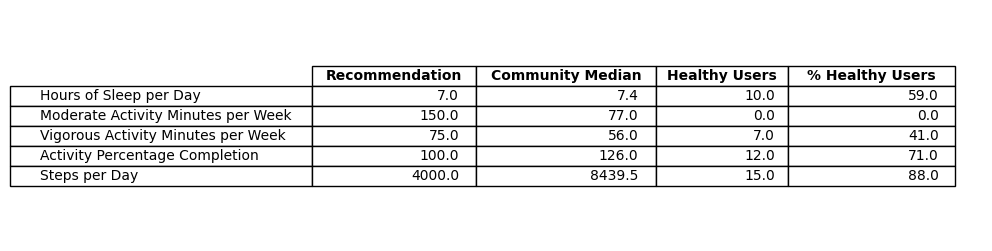

In [46]:

fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

standards_table = standards_table.set_index("Metric")

tbl = table(ax, standards_table, loc="center", colWidths=[0.2] * len(standards_table.columns))

tbl.auto_set_column_width([0, 1, 2])
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

# Apply bold for column headers
for (i, j), cell in tbl.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize=14)
    else:
        cell.set_text_props(fontsize=12)

#plt.savefig("standards_table.png", dpi=2000, bbox_inches="tight")

plt.show()

 The community adherence to established recommendations can be seen in Table 1. The community median for daily sleep duration was 7.4 hours, slightly exceeding the recommended 7 hours per night. This suggests that the majority of users are close to meeting the recommended amount of sleep for optimal health. However, only 59% of users consistently achieve this standard, indicating that while the community as a whole performs well, a significant proportion of individuals may experience insufficient sleep, potentially leading to health concerns associated with chronic sleep deprivation.

 For physical activity, the community median for moderate-intensity activity was 77 minutes per week, just over half of the minimum 150-minute recommendation. Vigorous-intensity activity showed a similar trend, with a community median of 56 minutes per week compared to the recommended 75 minutes. As expected, relatively few users meet the guidelines when moderate or vigorous activity is considered in isolation—0% and 41%, respectively. This is because the guidelines accommodate flexibility: while either moderate or vigorous activity alone can fulfill the recommendation, most individuals engage in a combination of both. To address this, a combined activity percentage metric was calculated. For the community, this metric considers both moderate and vigorous activities proportionally. For example, 40 minutes of vigorous activity (approximately half the requirement) and 75 minutes of moderate activity (half the moderate requirement) together satisfy the guideline, as the combined activity percentage exceeds 100%. Using this holistic approach, the community median reached 126%, and 71% of users met the activity recommendation.

 Daily step counts were a standout metric, with a community median of 8,439.5 steps—more than double the recommended minimum of 4,000 steps per day. This suggests that walking is a primary form of physical activity for most users. A notable 88% of users met or exceeded this guideline, indicating strong adherence to this aspect of physical activity. The high compliance rate highlights that walking is both a feasible and popular activity, making it an effective measure for promoting overall health.

# Sleep Patterns

Understanding the sleeping patterns of the community is a crucial aspect of this analysis. By examining how consistently individuals sleep and wake, we can gain insights into their daily routines, identify potential disruptions, and evaluate adherence to healthy sleep schedules. A review carried out by Chaput et al. (2020) concluded that consistent sleep patterns are associated with better overall health, mood, and cognitive function, while irregular sleep schedules can lead to a range of health issues, including fatigue, poor mental health, and sleep disorders. The review also highlights that later bedtimes and wake-up times are linked to poorer mental health and cognitive function, emphasizing the importance of maintaining earlier and regular sleep schedules for optimal health outcomes.


To analyze the sleeping patterns of the community, we calculated the average sleep and wake times for each user using the circular mean, which accounts for the cyclical nature of time, as previously mentioned (Lee, 2010). This approach ensures that times close to each other, such as late-night and early-morning hours, are treated as being near one another. Along with the mean, we also calculated the circular standard deviation (Lee, 2010), which measures the variability in sleep and wake times. The circular standard deviation is calculated by first converting the sleep and wake times into radians, as time is cyclical. The sine and cosine components of these values are then averaged, and the resulting vector length is used to compute the standard deviation. A lower circular standard deviation indicates a more consistent sleep schedule, while a higher value suggests greater irregularity. The combination of the circular mean and standard deviation provides a comprehensive view of both the average sleep and wake times and the consistency of these patterns across the user base.


In [47]:
def circular_std(series):
  """
  Calculate the circular standard deviation for a series of time-based data (e.g., hours).

  Parameters:
  ----------
  series : pd.Series or list
      A series or list of time values (in hours). It is assumed that the values represent
      hours on a 24-hour clock and are provided in a continuous scale (e.g., 0-23 hours).

  Returns:
  -------
  float
      The circular standard deviation in hours, representing the variability of the times.
  """
  radians = np.deg2rad(series * 15)  # Convert hours to radians
  sin_component = np.sin(radians)
  cos_component = np.cos(radians)

  # Compute the vector length (the mean radius)
  R = np.sqrt(np.mean(sin_component)**2 + np.mean(cos_component)**2)

  # Calculate the circular standard deviation
  circular_std = np.sqrt(-2 * np.log(R))

  # Convert back to hours (from radians)
  circular_std_hours = (np.rad2deg(circular_std) / 15) % 24
  return circular_std_hours

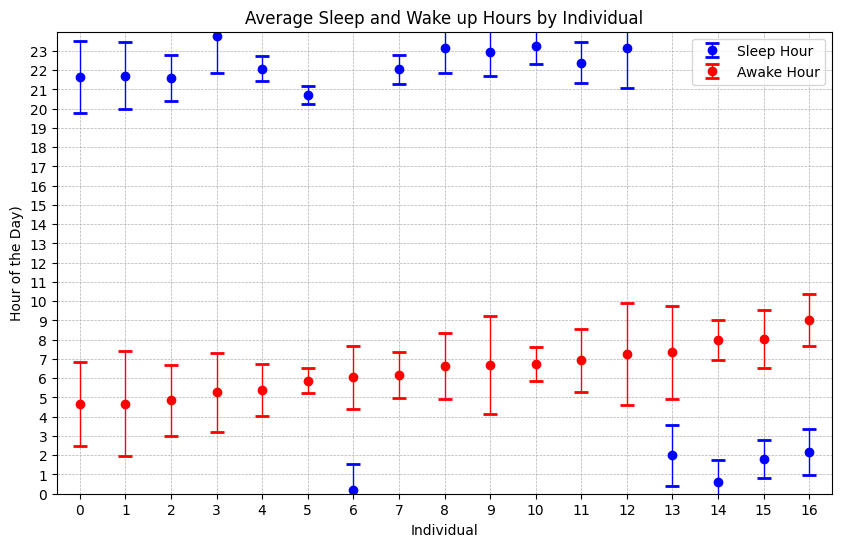

In [48]:
results = final_df.groupby('Id').agg(
    SleepHour=("SleepHour", lambda x: circular_mean(x)),
    AwakeHour=("AwakeHour", lambda x: circular_mean(x)),
    SleepStd=("SleepHour", lambda x: circular_std(x)),
    AwakeStd=("AwakeHour", lambda x: circular_std(x))
).reset_index().sort_values(by='AwakeHour')

results["reportId"] = results.reset_index(drop=True).reset_index().index.astype(int)
plt.figure(figsize=(10, 6))


# Add error bars for the circular standard deviation
plt.errorbar(results["reportId"], results['SleepHour'], yerr=results['SleepStd'], fmt='o', color='blue',
             label='Sleep Hour', capsize=5, elinewidth=1, capthick=2)

plt.errorbar(results["reportId"], results['AwakeHour'], yerr=results['AwakeStd'], fmt='o', color='red',
             label='Awake Hour', capsize=5, elinewidth=1, capthick=2)




plt.title("Average Sleep and Wake up Hours by Individual")
plt.xlabel("Individual")
plt.ylabel("Hour of the Day)")
plt.xticks(np.arange(0, len(results), 1))
plt.yticks(np.arange(0, 24, 1))
plt.xlim(-0.5, len(results)-0.5)
plt.ylim(0, 24)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

#plt.savefig("sleep_schedules.png", dpi=2000, bbox_inches="tight")

plt.show()

In [49]:
correlation, p_value = pearsonr(results["AwakeStd"], results["SleepStd"])

print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")

Correlation: 0.8131109884676049
P-value: 7.231926233328163e-05


The visualization depicts the average sleep and wake-up times of all users, along with the variability of these patterns, represented by error bars indicating circular standard deviation. The results highlight a diverse range of sleeping habits, with notable trends and outliers. The visualization is ordered by average wake up time.

Most individuals tend to go to bed between 8 PM and midnight, showing a relatively consistent bedtime schedule. However, a few individuals, particularly those labeled as 13–16, sleep significantly later, with bedtimes between midnight and 3 AM. The variability in sleep times, as indicated by the error bars, is generally small for most individuals, reflecting regular bedtime habits. Nevertheless, a few outliers display higher variability, indicating irregular sleep schedules or inconsistencies in their routines.

Wake-up times cluster primarily between 5 AM and 8 AM for the majority of individuals, but some individuals wake up as early as 4am. None of the users wake up what would normally be considered late. Variability in wake times is often higher than for sleep times, suggesting that individuals are less consistent in their waking routines. For certain participants, such as individuals 1, 9, 12, and 13, significant variability in wake-up times suggests irregular or disrupted morning schedules.

We can observe that individuals who sleep later tend to wake up later, while earlier sleepers wake earlier. We also notice that individuals with high variability in sleep time also tend to have a high variability in wake up time, in fact, the pearson coefficient (Benesty et al., 2009) between their standard deviations is 0.81 with a significant p-value of less than 0.01.



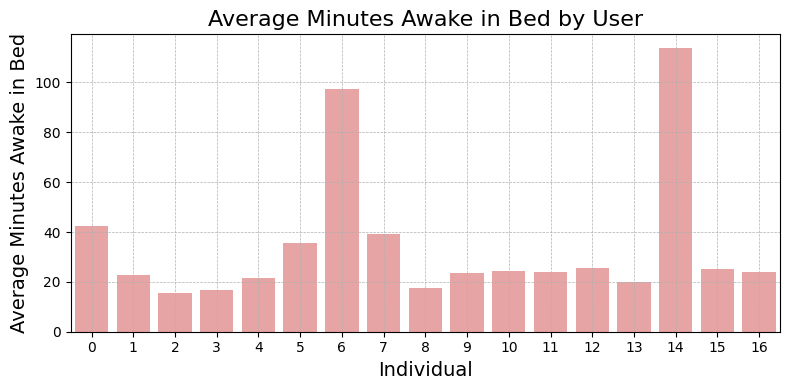

In [50]:
user_awake_avg = descriptive_df[['Id','MinutesAwakeBed']].copy()
user_awake_avg["Id"] = user_awake_avg[['Id']].merge(results[["Id", "reportId"]], on="Id")["reportId"].astype(int)
user_awake_avg = user_awake_avg.sort_values("Id")



user_awake_avg = user_awake_avg.groupby('Id').agg(
    MinutesAwakeBed=('MinutesAwakeBed', 'mean')
).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='Id', y='MinutesAwakeBed', data=user_awake_avg, alpha=0.8,color='lightcoral')

plt.title('Average Minutes Awake in Bed by User', fontsize=16)
plt.xlabel('Individual', fontsize=14)
plt.ylabel('Average Minutes Awake in Bed', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(ticks=plt.xticks()[0], labels=[int(tick) for tick in plt.xticks()[0]])

#plt.savefig("insomnia.png", dpi=2000, bbox_inches="tight")


plt.tight_layout()
plt.show()

Another important aspect of the analysis is the time users spend awake in bed before falling asleep, as this can help identify potential sleep disorders, such as insomnia. The plot highlights this data, showing that individuals 6 and 14 spend an average of about two hours in bed without sleeping, a possible indicator of insomnia or disrupted sleep schedules. Interestingly, these same individuals were observed in the pevious plot to have significantly later bedtimes, further suggesting issues with their sleep patterns. In contrast, the rest of the users display relatively normal time-to-sleep durations.


# Overall Sleep and activity relationship comparisons




To further understand the interplay between sleep and activity metrics, we conducted a correlation analysis of the user summary data. The purpose of this analysis was to explore the relationships between various sleep and activity variables, particularly focusing on how sleep metrics relate to physical activity metrics. The calculations of the circular standard deviation for sleep and wake times, as well as the average and standard deviations for other variables like total sleep time, steps, and activity minutes, were aggregated for each user. The resulting correlations were visualized in a heatmap, providing insights into the interactions between sleep habits and physical activity patterns.

In [51]:
user_summaries_df = descriptive_df.groupby('Id').agg(
    SleepHourStd=("SleepHour", lambda x: circular_std(x)),
    AwakeHourStd=("AwakeHour", lambda x: circular_std(x)),
    TotalMinutesAsleepAvg=("TotalMinutesAsleep", "mean"),
    TotalMinutesAsleepStd=("TotalMinutesAsleep", "std"),
    MinutesAwakeBedAvg=("MinutesAwakeBed", "mean"),
    TotalStepsAvg=("TotalSteps", "mean"),
    ActiveMinutesAvg=("ActiveMinutes", "mean"),
    CaloriesAvg=("Calories", "mean"),
    LightlyActiveMinutesAvg=("LightlyActiveMinutes", "mean"),
).reset_index()

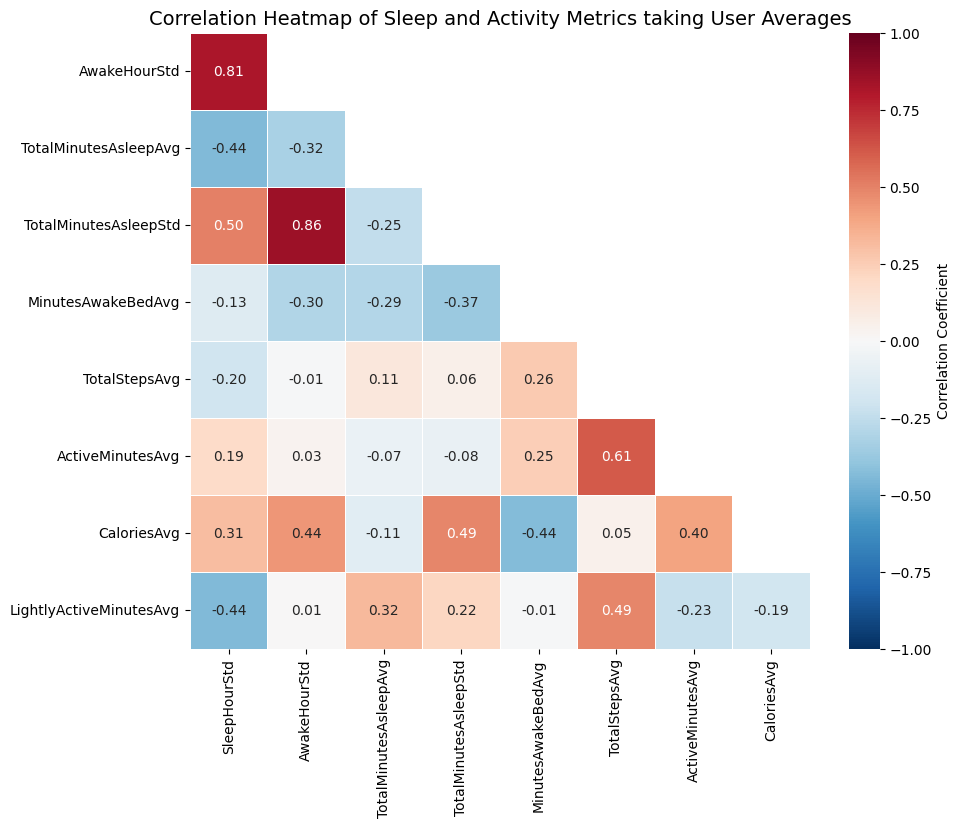

In [52]:
corr_matrix = user_summaries_df.drop(columns="Id").corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

np.fill_diagonal(corr_matrix.values, np.nan)

# Removes the first column and last row for redability
corr_matrix = corr_matrix.iloc[1:, :-1]
mask = mask[1:, :-1]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5,
            vmin=-1, vmax=1, mask=mask, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Sleep and Activity Metrics taking User Averages', fontsize=14)
#plt.savefig("user_summaries_corr_matrix.png", dpi=2000, bbox_inches="tight")
plt.show()

The heatmap shown reveals several interesting correlations between sleep and activity metrics. A key finding is the negative correlation between Sleep Hour Standard Deviation and Light Active Minutes Average (-0.44), suggesting that irregular sleep may lead to lower light activity levels. Disrupted sleep can affect energy and motivation, potentially resulting in less physical activity. This is supported by the positive correlation between Sleep Hour Standard Deviation and Calories Average (0.31), which indicates that irregular sleep patterns may increase calorie expenditure, possibly due to metabolic adjustments.

Looking at Minutes Awake in Bed Average, there’s a negative correlation with Calories Average (-0.44), suggesting that people who spend more time awake in bed, perhaps due to poor sleep quality, may burn fewer calories. However, the positive correlation between Minutes Awake in Bed Average and Active Minutes Average (0.25) complicates this, implying that longer awake times may lead to more activity, but the overall effect on physical activity could be influenced by other factors.
A positive correlation between Total Minutes Asleep Average and Light Active Minutes Average (0.32) suggests that more sleep is linked to more light activity. However, the relationship with higher-intensity activity, like Active Minutes Average, is weak (0.19), indicating that sleep mainly influences less intense physical activities. Lastly, Total Minutes Asleep Standard Deviation’s moderate positive correlation with Calories Average (0.49) supports the idea that irregular sleep is associated with higher calorie expenditure, possibly due to the body’s response to inconsistent sleep schedules.

The main takeaway from the analysis is that irregular sleep patterns seem to be linked to both lower light activity and higher calorie expenditure, while more sleep is associated with increased light activity. However, it’s important to note that these are correlations, not causations, and we cannot draw definitive conclusions about cause-and-effect relationships. As previously stated, with only 17 users in the sample, these findings are not very generalizable, and the small sample size limits the ability to make strong conclusions.



# Cluster Analysis

This section focuses on applying cluster analysis to uncover behavioral profiles based on users' sleep patterns, with the aim of identifying distinct sleeper types. By clustering only on sleep variables, we can more effectively isolate sleep behavior from activity patterns, which is crucial for understanding how sleep influences daily activity. The clustering will help classify users into different sleeper types, which can then be used to investigate the relationship between sleep and physical activity levels. After clustering, an ANOVA test will be conducted to assess if there are significant differences in activity metrics (such as steps, active minutes, and calories) between the identified sleeper types. The clustering will include sleep variables, such as total sleep time, sleep duration consistency, and average sleep and awake times. To account for the cyclical nature of time, both sleep and awake times will be transformed using cosine and sine functions. This transformation is necessary because it accurately captures the circular nature of time: the cosine function represents the horizontal position of the time relative to midnight, while the sine function captures the vertical position, reflecting how far the time is from the peak of the 24-hour cycle (e.g., noon or midnight) (Lee, 2010). This approach ensures a more precise representation of time in the clustering process.

In [53]:
user_summaries_df = descriptive_df.groupby('Id').agg(
    SleepHour=("SleepHour", lambda x: circular_mean(x)),
    AwakeHour=("AwakeHour", lambda x: circular_mean(x)),
    SleepHourStd=("SleepHour", lambda x: circular_std(x)),
    AwakeHourStd=("AwakeHour", lambda x: circular_std(x)),
    TotalMinutesAsleepAvg=("TotalMinutesAsleep", "mean"),
    TotalMinutesAsleepStd=("TotalMinutesAsleep", "std"),
    MinutesAwakeBedAvg=("MinutesAwakeBed", "mean"),
).reset_index()


# Add sine and cosine transformations for SleepHour and AwakeHour
user_summaries_df['SleepHourCos'] = np.cos(user_summaries_df['SleepHour'] * (2 * np.pi / 24))
user_summaries_df['SleepHourSin'] = np.sin(user_summaries_df['SleepHour'] * (2 * np.pi / 24))
user_summaries_df['AwakeHourCos'] = np.cos(user_summaries_df['AwakeHour'] * (2 * np.pi / 24))
user_summaries_df['AwakeHourSin'] = np.sin(user_summaries_df['AwakeHour'] * (2 * np.pi / 24))

user_summaries_df = user_summaries_df.drop(columns=["SleepHour", "AwakeHour"])

The K-means clustering (MacQueen, 1967) will be used to group users based on their sleep and activity patterns. K-means is a widely used algorithm that assigns data points to clusters based on their similarity, minimizing the variance within each cluster. To enhance the performance of K-means, especially with high-dimensional data, Principal Component Analysis (PCA) (Hotelling, 1933) will be applied as a preprocessing step. PCA reduces the dimensionality of the data by transforming it into a smaller set of uncorrelated components that capture the most variance. This not only reduces computational complexity but also helps mitigate issues like the curse of dimensionality and noise, improving the quality of the clusters. Ding and He (2004) demonstrated that combining PCA with K-means can improve clustering outcomes by focusing on the most informative components of the data, thus enhancing both efficiency and interpretability.

In [54]:
features_cluster = [col for col in user_summaries_df if col != "Id"]
cluster_data = user_summaries_df.copy()[features_cluster]

scaler = StandardScaler()
cluster_data = scaler.fit_transform(cluster_data)

pca = PCA(n_components=3)
cluster_data = pca.fit_transform(cluster_data)
np.cumsum(pca.explained_variance_ratio_)

array([0.33556398, 0.64534911, 0.77289203])

In cluster analysis, it is common to retain about 80% of the variability when performing Principal Component Analysis (PCA). In this case, we used 3 principal components, which accounted for approximately 77% of the total variability in the data.

In [55]:
def k_means(X, k):
    """
    Perform k-means clustering on the given data.

    Parameters
    ----------
    X : ndarray
        The data to be clustered.
    k : int
        The number of clusters.

    Returns
    -------
    clusters : ndarray
        The cluster labels.
    """
    kmeans = KMeans(n_clusters=k,random_state=42, max_iter=int(10e5), n_init=100)
    clusters = kmeans.fit_predict(X)
    return clusters

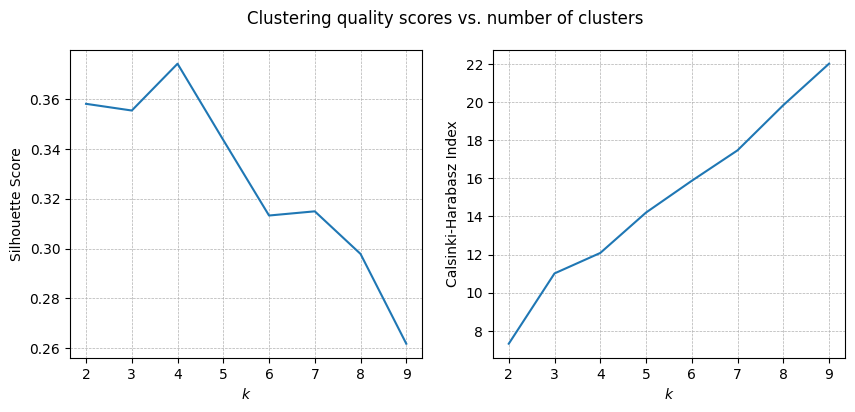

In [56]:
k_range = range(2, 10)
silhouette_scores = []
calsinki_indices = []

for k in k_range:
    clusters = k_means(cluster_data,k)
    silhouette_scores.append(silhouette_score(cluster_data,clusters))
    calsinki_indices.append(calinski_harabasz_score(cluster_data, clusters))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

axes[0].plot(k_range, silhouette_scores)
axes[0].set_xlabel("$k$"), axes[1].set_xlabel("$k$")
axes[0].set_ylabel("Silhouette Score")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

axes[1].plot(k_range, calsinki_indices)
axes[1].set_ylabel("Calsinki-Harabasz Index")
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

fig.suptitle("Clustering quality scores vs. number of clusters")
#plt.savefig("choosing_k.png", dpi=2000, bbox_inches="tight")

plt.show()


To choose the appropriate value of k for clustering, we use two evaluation metrics: the Silhouette Score and the Calinski-Harabasz Index. The Silhouette Score (Rousseeuw, 1987) measures how well-separated and defined the clusters are, with higher values indicating better-defined clusters. The Calinski-Harabasz Index (Calinski and Harabasz, 1974) evaluates the ratio of between-cluster dispersion to within-cluster dispersion, where higher values indicate more distinct and well-separated clusters. Taking both metrics into account and considering the small sample size, k=3 or k=4 seem as the most appropriate choices. For simplicity we take k=3 as it will provide a balance between capturing meaningful patterns in the data while avoiding excessive complexity, making it a more suitable option for this analysis.


In [57]:
# Recalculating user_summaries_df to add circular mean
cluster_df = descriptive_df.groupby('Id').agg(
    SleepHour=("SleepHour", lambda x: circular_mean(x)),
    AwakeHour=("AwakeHour", lambda x: circular_mean(x)),
    SleepHourStd=("SleepHour", lambda x: circular_std(x)),
    AwakeHourStd=("AwakeHour", lambda x: circular_std(x)),
    TotalMinutesAsleepAvg=("TotalMinutesAsleep", "mean"),
    TotalMinutesAsleepStd=("TotalMinutesAsleep", "std"),
    MinutesAwakeBedAvg=("MinutesAwakeBed", "mean"),
).reset_index()
cluster_df["Cluster"] = k_means(cluster_data,3)

In [58]:
cluster_df["Cluster"].value_counts()

,count
Cluster,
2,8
0,6
1,3


In [59]:
cluster_stats_1 = cluster_df.groupby("Cluster").agg(
    SleepHourAvg=("SleepHour", lambda x: circular_mean(x)),
    AwakeHourAvg=("AwakeHour", lambda x: circular_mean(x)),
    NumberOfUsers=("Id","count")).reset_index()

cluster_stats_2 = cluster_df.drop(columns=["SleepHour","AwakeHour","Id"]).groupby("Cluster").mean().reset_index()

cluster_stats = cluster_stats_1.merge(cluster_stats_2, on="Cluster")

In [60]:
cluster_stats

,Cluster,SleepHourAvg,AwakeHourAvg,NumberOfUsers,SleepHourStd,AwakeHourStd,TotalMinutesAsleepAvg,TotalMinutesAsleepStd,MinutesAwakeBedAvg
0,0,22.021238,5.997863,6,0.846862,1.261487,447.467106,79.500172,29.516416
1,1,1.536049,8.347984,3,1.090833,1.293223,338.957158,81.595580,65.868286
2,2,23.315748,6.072469,8,1.648263,2.235772,366.727029,114.768993,22.954055


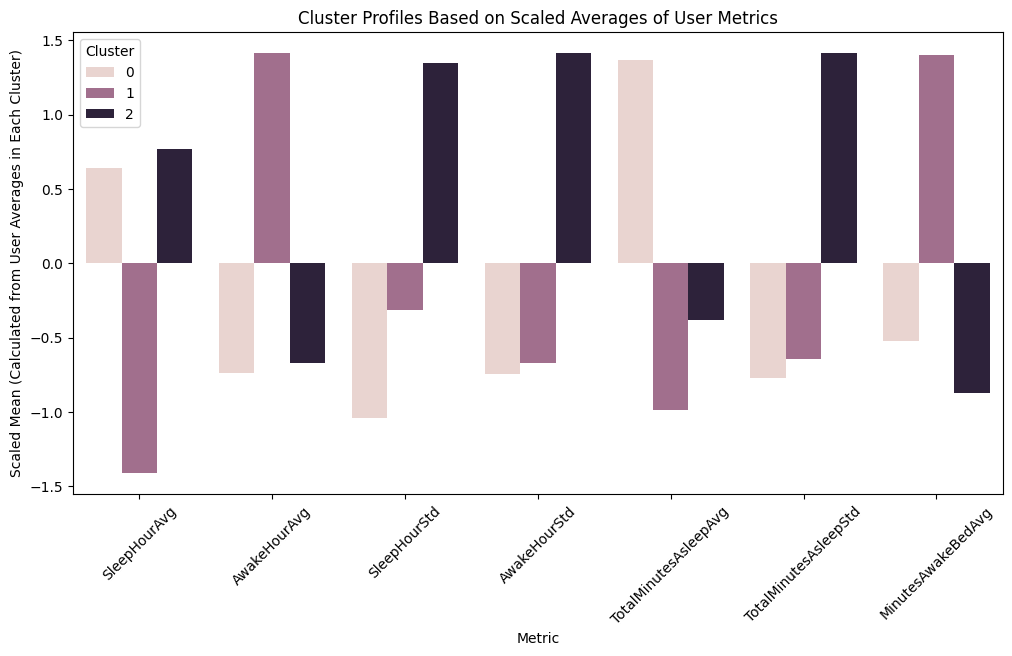

In [61]:
metrics_to_plot = [col for col in cluster_stats.columns if col not in ["Cluster","NumberOfUsers"]]  # Skip 'Cluster' and 'NumberOfUsers'
scaler = StandardScaler()

cluster_stats_scaled = scaler.fit_transform(cluster_stats[metrics_to_plot])
cluster_stats_scaled = pd.DataFrame(cluster_stats_scaled, columns=metrics_to_plot)
cluster_stats_scaled["Cluster"] = cluster_stats["Cluster"]

long_df = cluster_stats_scaled.melt(id_vars=["Cluster"], value_vars=metrics_to_plot, var_name="Metric", value_name="Mean")

plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x="Metric", y="Mean", hue="Cluster")
plt.xticks(rotation=45)
plt.title("Cluster Profiles Based on Scaled Averages of User Metrics")
plt.ylabel("Scaled Mean (Calculated from User Averages in Each Cluster)")
plt.xlabel("Metric")
plt.legend(title="Cluster")
#plt.savefig("cluster_sleep_stats.png", dpi=2000, bbox_inches="tight")

plt.show()

The three defined clusters are made up of 6, 3 and 8 users respectively. Based on the cluster analysis, three distinct sleep profiles were identified, as visualized in Fig. 9. Cluster 0, termed Regular Healthy Sleepers, represents users with consistent sleep and wake times (average sleep time of 10 PM and wake time of 6 AM, not visible in the scaled plot), low variability in sleep-related metrics, and the highest average sleep duration of approximately 7.5 hours, aligning with WHO recommendations for healthy sleep. Cluster 1, described as Night Owls with Insomnia , consists of users who sleep the latest (indicated by the lowest scaled values in sleep time, as after midnight is represented as a lower value), wake up the latest, and experience the shortest sleep durations. They also spend the most time awake in bed, potentially reflecting difficulty falling or staying asleep. Finally, Cluster 2, labeled Irregular Sleepers, includes users with the most variability in their sleep and wake times as well as total sleep duration, indicating a lack of consistent sleep patterns. These profiles highlight the diversity in sleeping behaviors and set the stage for further analysis of how these patterns relate to physical activity metrics.




In [62]:
user_activity_summaries_df = descriptive_df[['Id','TotalSteps','ActiveMinutes','LightActiveDistance', 'Calories']].groupby('Id').mean().reset_index()
user_activity_summaries_df = user_activity_summaries_df.merge(cluster_df[['Id','Cluster']], on="Id")
cluster_activity_stats = user_activity_summaries_df.drop(columns="Id").groupby("Cluster").mean().reset_index()


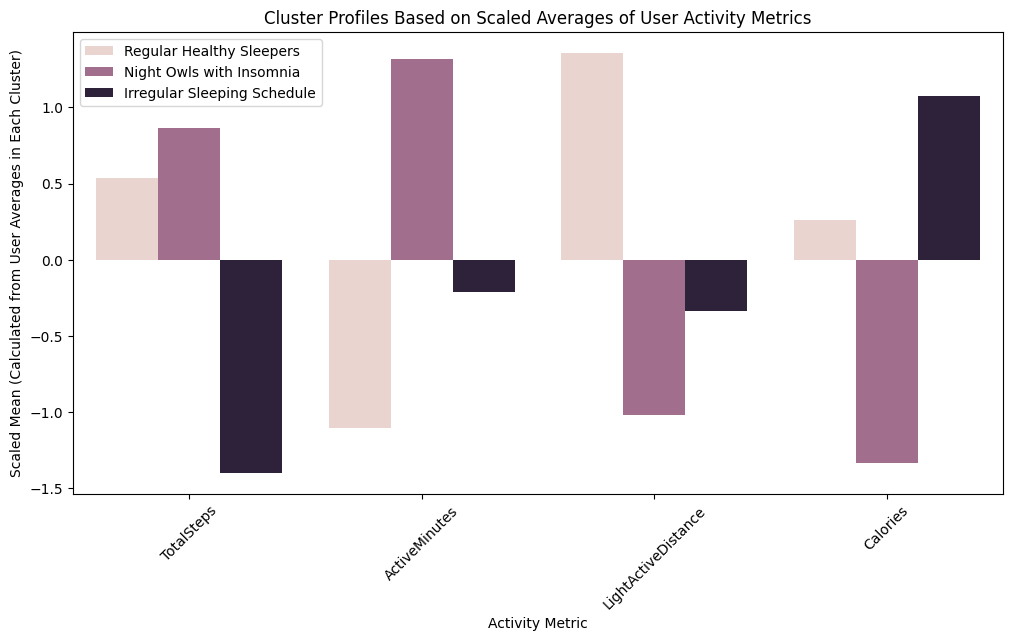

In [63]:
metrics_to_plot = [col for col in cluster_activity_stats.columns if col not in ["Cluster"]]
scaler = StandardScaler()

cluster_activity_stats_scaled = scaler.fit_transform(cluster_activity_stats[metrics_to_plot])
cluster_activity_stats_scaled = pd.DataFrame(cluster_activity_stats_scaled, columns=metrics_to_plot)
cluster_activity_stats_scaled["Cluster"] = cluster_activity_stats["Cluster"]

long_df = cluster_activity_stats_scaled.melt(id_vars=["Cluster"], value_vars=metrics_to_plot, var_name="Metric", value_name="Mean")


plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x="Metric", y="Mean", hue="Cluster")
plt.xticks(rotation=45)
plt.title("Cluster Profiles Based on Scaled Averages of User Activity Metrics")
plt.ylabel("Scaled Mean (Calculated from User Averages in Each Cluster)")
plt.xlabel("Activity Metric")

# Rename legend labels
new_labels = {
    "0": "Regular Healthy Sleepers",
    "1": "Night Owls with Insomnia",
    "2": "Irregular Sleeping Schedule"
}

handles, labels = plt.gca().get_legend_handles_labels()
labels = [new_labels[label] for label in labels]
plt.legend(handles, labels)
#plt.savefig("cluster_activity_stats.png", dpi=2000, bbox_inches="tight")
plt.show()

Based on the activity metrics shown, three distinct patterns emerge across the clusters. Regular Healthy Sleepers display moderate levels of activity across all metrics. Their total steps and active minutes are near the average, with a slight positive trend in light active distance and calories burned. This suggests a balanced level of physical activity, consistent with their stable sleep patterns. Night Owls with Insomnia stand out with significantly higher total steps and active minutes compared to the Regular Healthy Sleepers. These users are notably more engaged in physical activity, as seen in their higher total steps and active minutes scores. However, their light active distance and calories burned are lower, potentially indicating more intense but less frequent activity. Their sleep disturbances may lead them to expend more energy during the day in an attempt to counteract poor sleep quality. Irregular Sleepers display the most pronounced variation in activity. While their total steps and active minutes are lower compared to the Night Owls with Insomnia, their calories burned and light active distance are higher, suggesting that although they may not engage in consistent, structured physical activity, their erratic sleep patterns might lead to bursts of energy expenditure throughout the day. This irregularity in both sleep and activity metrics reflects a less predictable relationship between sleep quality and activity levels in this group.

# Kruskal Wallis Test on Activity Metrics by Cluster


ANOVA is a statistical method used to determine if there are any significant differences between the means of multiple groups (Fisher, 1970). In this analysis, we are using ANOVA to assess whether there are significant differences in activity metrics across the different sleeper types identified by clustering. Instead of conducting the test on the small number of users, we will perform the ANOVA on all the daily records within each cluster. This approach increases the number of data points, improving the statistical power of the analysis. While it would be ideal to perform the test by user, the small sample size limits that approach, making the analysis of daily records a more feasible method for obtaining reliable results. Although the ANOVA is based on daily records rather than individual users, it still provides valuable insights by highlighting how sleep patterns influence activity levels across multiple days, offering a more comprehensive understanding of the sleep-activity relationship.

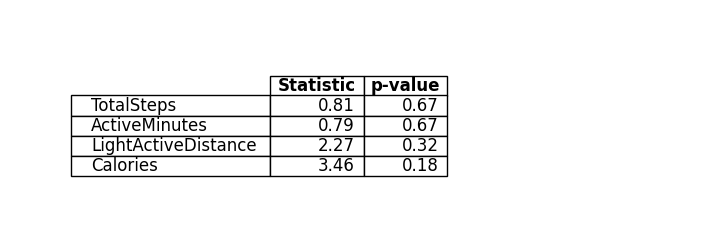

In [64]:
hypothesis_test_df = user_activity_summaries_df.drop(columns="Id")

variables = ['TotalSteps', 'ActiveMinutes', 'LightActiveDistance', 'Calories']

results = []

# Perform Kruskal-Wallis test for each variable
for var in variables:
    group_0 = hypothesis_test_df[hypothesis_test_df['Cluster'] == 0][var]
    group_1 = hypothesis_test_df[hypothesis_test_df['Cluster'] == 1][var]
    group_2 = hypothesis_test_df[hypothesis_test_df['Cluster'] == 2][var]

    stat, p_value = kruskal(group_0, group_1, group_2)

    results.append([var, stat, p_value])

results_df = pd.DataFrame(results, columns=['Metric', 'Statistic', 'p-value']).set_index("Metric")
results_df["Statistic"] = results_df["Statistic"].round(2)
results_df["p-value"] = results_df["p-value"].round(2)

fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

tbl = table(ax, results_df, loc="center", colWidths=[0.2] * len(results_df.columns))

tbl.auto_set_column_width([0, 1, 2, 3])
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

for (i, j), cell in tbl.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize=14)
    else:
        cell.set_text_props(fontsize=12)

#plt.savefig("hypothesis_testing.png", dpi=2000, bbox_inches="tight")
plt.show()


The null hypothesis for the Kruskal-Wallis test in this context is that the different sleep profiles have the same central tendency in their activity metrics, meaning they come from the same population. The alternative hypothesis is that at least one sleep profile exhibits a different central tendency in activity metrics, suggesting that it comes from a different population.

As shown in the table the results of the Kruskal-Wallis tests for all activity metrics have a p-value > 0.05, thus, we fail to reject the null hypothesis for all metrics, implying that there is no substantial evidence to suggest that the activity patterns differ between the different sleeper types. While the statistical tests found no differences, it is important to note that the small sample sizes within each group may limit the statistical power of the tests, making it more challenging to detect meaningful differences. This limitation suggests that, although no differences were found, there may still be subtle effects that were not detected due to the low power of the tests associated with small sample sizes.

# Conclusion


## Limitations & Shortcomings
Several limitations affected the study’s outcomes and potential impact. The small sample size of 17 users limited the ability to draw generalizable conclusions. If a larger, more diverse dataset had been used, it would allow for more robust statistical analysis, possibly uncovering stronger relationships and validating the trends observed in this study. Additionally, missing data for sleep and activity metrics, which, despite using advanced techniques, introduces the possibility of bias. Avoiding missing data would enhance the reliability of results and allow for a fuller exploration of relationships between variables, while also allowing to analyze other factors like resting heart rate, which were excluded from some analyses due to insufficient data.
The short data collection period of two months further restricted the study’s scope. A longer observation period would enable the identification of seasonal or long-term trends in sleep and activity behaviors. Furthermore, the dataset lacked demographic details, such as age, gender, and occupation, which are critical for contextualizing sleep and activity patterns. Incorporating this information could lead to more nuanced analyses and enable targeted interventions based on individual characteristics.

## Future Steps
Future research should address these limitations by incorporating larger, more diverse datasets and extending the observation period. This would improve the generalizability of findings and allow for the exploration of temporal trends. Demographic data should also be integrated to examine how age, gender, and lifestyle factors influence sleep-activity relationships. Expanding the scope of metrics to include variables such as diet, mental health, and stress levels would provide a more comprehensive understanding of the factors influencing sleep and activity.
Building on the cluster analysis, future studies could use larger populations to test whether the identified sleep profiles correlate with distinct activity behaviors across different contexts. For example, it would be valuable to explore how a recommendation system, tailored to each sleep profile, could guide individuals toward healthier behaviors. By providing personalized suggestions based on users' specific sleep and activity patterns, wearables like Fitbit could be used to track progress and assess how well these tailored recommendations improve long-term health outcomes. Additionally, incorporating surveys to track users' health status, such as mental well-being, stress levels, and overall satisfaction with the recommendations, could provide a more holistic understanding of the effectiveness of such systems. This type of research could demonstrate the potential of wearables and data-driven health recommendations in enhancing health behaviors, improving long-term health outcomes, and promoting overall well-being.

## Summary
In summary, while the findings support the existing literature on the relationship between sleep and physical activity, the limitations in data quality prevent these results from being broadly generalized. Nevertheless, the study provides useful insights into how sleep regularity may affect activity levels and highlights the importance of further research in this area. The observed trends suggest that detecting sleep habits could be a key factor in promoting better physical activity and overall health through the use of wearable devices like Fitbit, but larger, more diverse studies are needed to validate these findings.
